In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

import time

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### AIR POLLUTION MONITORING DATA FROM EDF

In [2]:
    df = pd.read_csv('EDF_Data.csv', header = 1)
    df['TimePeriod'] = 'Jun2015-May2016'
    df.tail()

Longitude   Latitude    NO Value  NO2 Value  BC Value       TimePeriod
21483 -122.034943  37.560076  129.999995  44.778220  3.923761  Jun2015-May2016
21484 -122.034724  37.560164   60.799998  39.027545  1.408693  Jun2015-May2016
21485 -122.034681  37.559830   34.622951  28.816797  2.659885  Jun2015-May2016
21486 -122.034504  37.559958   74.764705  35.735434  1.776353  Jun2015-May2016
21487 -122.034503  37.559957   78.754782  41.062757  2.014664  Jun2015-May2016

In [3]:
df.shape

(21488, 6)

In [4]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

### Split the dataset into BC and NO2 since we are interested only in those two pollutants

In [141]:
BC_df = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [142]:
NO2_df = df[['Longitude', 'Latitude', 'NO2 Value', 'TimePeriod']]

In [143]:
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

### FACILITY LEVEL DATA

In [5]:
# Read data for Oakland and drop duplicate facility ids
oak_facility = pd.read_csv('Data/oakland_facility_2017.csv', header = 0)
# Display all columns in the dataframe
oak_facility.columns

Index(['Unnamed: 0', 'county', 'eis facility id', 'agency facility id',
       'tri facility id', 'company name', 'site name', 'facility source type',
       'site latitude', 'site longitude', 'address', 'city', 'zip code',
       'pollutant code', 'pollutant type(s)', 'total emissions',
       'emissions uom', 'data set'],
      dtype='object')

In [6]:
# Drop columns that are not needed 
oak_facility.drop(columns = ['agency facility id', 'tri facility id','pollutant type(s)', 'data set',
                             'site name', 'address','Unnamed: 0', 'county'], inplace=True)

In [7]:
# Rename site latitude and site longitude column to just latitude and logitude
oak_facility.rename(columns={"site latitude": "latitude", "site longitude": "longitude", 'facility source type':'source-category'}, inplace=True)

In [8]:
# Display all columns in the dataframe
oak_facility.columns

Index(['eis facility id', 'company name', 'source-category', 'latitude',
       'longitude', 'city', 'zip code', 'pollutant code', 'total emissions',
       'emissions uom'],
      dtype='object')

In [9]:
# Filter the dataframe further for sources/facilities only in Oakland and neighbouring cities like San Leandro, Piedmont, Alameda and Berkeley
oak_facility = oak_facility[(oak_facility['city'] == 'OAKLAND') | (oak_facility['city'] == 'SAN LEANDRO') | (oak_facility['city'] == 'BERKELEY')|
                           (oak_facility['city'] == 'ALAMEDA') | (oak_facility['city'] == 'PIEDMONT')]

In [10]:
oak_facility.head(50)

eis facility id                    company name  \
3             126911                    PACIFIC BELL   
4             126911                    PACIFIC BELL   
5             126911                    PACIFIC BELL   
9             127111                    PACIFIC BELL   
10            127111                    PACIFIC BELL   
11            127111                    PACIFIC BELL   
18            127511                    PACIFIC BELL   
19            127511                    PACIFIC BELL   
20            127511                    PACIFIC BELL   
21            127611                    PACIFIC BELL   
22            127611                    PACIFIC BELL   
23            127611                    PACIFIC BELL   
24            127711                    PACIFIC BELL   
25            127711                    PACIFIC BELL   
26            127711                    PACIFIC BELL   
27            127811                    PACIFIC BELL   
28            127811                    PACIFIC BELL   
29            127811                    PACIFIC BELL   
33            128211                    PACIFIC BELL   
34            128211                    PACIFIC BELL   
35            128211                    PACIFIC BELL   
48            130511               KAISER PERMANENTE   
49            130511               KAISER PERMANENTE   
50            130511               KAISER PERMANENTE   
51            136511     NORTHERN CALIF POWER AGENCY   
52            136511     NORTHERN CALIF POWER AGENCY   
53            136511     NORTHERN CALIF POWER AGENCY   
54            137211  KAISER PERMANENTE MEDICAL CENT   
55            137211  KAISER PERMANENTE MEDICAL CENT   
56            137211  KAISER PERMANENTE MEDICAL CENT   
63            137811            UNCOMMON GROUNDS,INC   
64            137811            UNCOMMON GROUNDS,INC   
65            137811            UNCOMMON GROUNDS,INC   
77            138911    PRECISION TECHNICAL COATINGS   
78            138911    PRECISION TECHNICAL COATINGS   
81            139211   AGRICULTURAL RESEARCH SERVICE   
82            139211   AGRICULTURAL RESEARCH SERVICE   
83            139211   AGRICULTURAL RESEARCH SERVICE   
86            140211  SVC MANUFACTURING, INC DBA PEP   
87            140211  SVC MANUFACTURING, INC DBA PEP   
88            140211  SVC MANUFACTURING, INC DBA PEP   
101           141411   AC TRANSIT DISTRICT - CENTRAL   
102           141411   AC TRANSIT DISTRICT - CENTRAL   
103           141411   AC TRANSIT DISTRICT - CENTRAL   
107           168111  EAST BAY DISCHARGERS AUTHORITY   
108           168111  EAST BAY DISCHARGERS AUTHORITY   
109           168111  EAST BAY DISCHARGERS AUTHORITY   
113           168411                       CASS, INC   
114           168411                       CASS, INC   
115           168411                       CASS, INC   

                                    source-category  latitude  longitude  \
3                                               NaN  37.76685 -122.24972   
4                                               NaN  37.76685 -122.24972   
5                                               NaN  37.76685 -122.24972   
9                                               NaN  37.86771 -122.26784   
10                                              NaN  37.86771 -122.26784   
11                                              NaN  37.86771 -122.26784   
18                                              NaN  37.80603 -122.26946   
19                                              NaN  37.80603 -122.26946   
20                                              NaN  37.80603 -122.26946   
21                                              NaN  37.78422 -122.22241   
22                                              NaN  37.78422 -122.22241   
23                                              NaN  37.78422 -122.22241   
24                                              NaN  37.83336 -122.26307   
25                                              NaN  37.83336 -122.26307   
26      

In [11]:
### First clean up source-category column
oak_facility['source-category'] = oak_facility['source-category'].replace({'Institutional (school, hospital, prison, etc.)':'Institution', 'Breweries/Distilleries/Wineries':'Breweries-Distilleries-Wineries'})
oak_facility.replace(' ', '-',regex=True,inplace=True)
oak_facility.replace(',', '-',regex=True,inplace=True)
oak_facility.replace('---', '-',regex=True,inplace=True)
oak_facility.replace('--', '-',regex=True,inplace=True)
oak_facility.replace(np.nan, 'Unknown', regex= True, inplace=True)

In [12]:
oak_facility['source-category'].unique()


array(['Unknown', 'Institution', 'Electricity-Generation-via-Combustion',
       'Concrete-Batch-Plant', 'Hot-Mix-Asphalt-Plant',
       'Wastewater-Treatment-Facility', 'Crematory-Human',
       'Food-Products-Processing-Plant',
       'Breweries-Distilleries-Wineries',
       'Auto-Body-Painting-or-Repair-Shop', 'Foundries-Iron-and-Steel',
       'Fiberglass-Products-Manuf', 'Bakeries',
       'Dry-Cleaner-Petroleum-Solvent', 'Pharmaceutical-Manufacturing',
       'Landfill', 'Airport', 'Concrete-Block-Pipe-or-Other-Manuf'],
      dtype=object)

#### Before dropping columns, create a dataframe which has a mapping of EIS facility id and the source type; write into a separate dataframe
EIS_source_type = oak_facility[['eis facility id', 'company name','source-category','city']]
EIS_source_type.to_csv("Data/eis-source-type-mapping.csv")

In [13]:
## Creating a separate dataframe for NOx
Facility_NO2 = oak_facility[oak_facility['pollutant code'] == 'NOX']

In [14]:
Facility_NO2.shape

(328, 10)

eis facility id company name_x source-category_x  latitude_x  \
0             126911   PACIFIC-BELL           Unknown   37.766850   
1             127111   PACIFIC-BELL           Unknown   37.867710   
2             127511   PACIFIC-BELL           Unknown   37.806030   
3             127611   PACIFIC-BELL           Unknown   37.784220   
4             127711   PACIFIC-BELL           Unknown   37.833360   
..               ...            ...               ...         ...   
357         18778911        Unknown           Unknown   37.712960   
358         18779811        Unknown           Unknown   37.707820   
359         18781211        Unknown           Unknown   37.812106   
360         18782611        Unknown           Unknown   37.759959   
361         18787011        Unknown           Unknown   37.766939   

     longitude_x       city_x  zip code_x pollutant code_x  total emissions_x  \
0    -122.249720      ALAMEDA       94501         PM25-PRI           0.000731   
1    -122.267840     BERKELEY       94704         PM25-PRI           0.002173   
2    -122.269460      OAKLAND       94612         PM25-PRI           0.008291   
3    -122.222410      OAKLAND       94601         PM25-PRI           0.000706   
4    -122.263070      OAKLAND       94609         PM25-PRI           0.001554   
..           ...          ...         ...              ...                ...   
357  -122.188680  SAN-LEANDRO       94577         PM25-PRI          22.124544   
358  -122.185500  SAN-LEANDRO       94577         PM25-PRI           0.000015   
359  -122.186447      OAKLAND       94621         PM25-PRI           0.000061   
360  -122.207782      OAKLAND       94621         PM25-PRI           0.992654   
361  -122.216336      OAKLAND       94621         PM25-PRI           0.079014   

    emissions uom_x company name_y source-category_y  latitude_y  longitude_y  \
0               TON   PACIFIC-BELL           Unknown   37.766850  -122.249720   
1               TON   PACIFIC-BELL           Unknown   37.867710  -122.267840   
2               TON   PACIFIC-BELL           Unknown   37.806030  -122.269460   
3               TON   PACIFIC-BELL           Unknown   37.784220  -122.222410   
4               TON   PACIFIC-BELL           Unknown   37.833360  -122.263070   
..              ...            ...               ...         ...          ...   
357             TON        Unknown           Unknown   37.712960  -122.188680   
358             TON        Unknown           Unknown   37.707820  -122.185500   
359             TON        Unknown           Unknown   37.812106  -122.186447   
360             TON        Unknown           Unknown   37.759959  -122.207782   
361             TON        Unknown           Unknown   37.766939  -122.216336   

          city_y  zip code_y pollutant code_y  total emissions_y  \
0        ALAMEDA       94501         PM10-PRI           0.000749   
1       BERKELEY       94704         PM10-PRI           0.002226   
2        OAKLAND       94612         PM10-PRI           0.008494   
3        OAKLAND       94601         PM10-PRI           0.000724   
4        OAKLAND       94609         PM10-PRI           0.001592   
..           ...         ...              ...                ...   
357  SAN-LEANDRO       94577         PM10-PRI          22.971518   
358  SAN-LEANDRO       94577         PM10-PRI           0.000015   
359      OAKLAND       94621         PM10-PRI           0.000061   
360      OAKLAND       94621         PM10-PRI           1.030213   
361      OAKLAND       94621         PM10-PRI           0.131690   

    emissions uom_y  
0               TON  
1               TON  
2               TON  
3               TON  
4               TON  
..              ...  
357             TON  
358             TON  
359             TON  
360             TON  
361             TON  

[362 rows x 19 columns]

eis facility id       company source-category  latitude  longitude  \
0           126911  PACIFIC-BELL         Unknown  37.76685 -122.24972   
1           127111  PACIFIC-BELL         Unknown  37.86771 -122.26784   
2           127511  PACIFIC-BELL         Unknown  37.80603 -122.26946   
3           127611  PACIFIC-BELL         Unknown  37.78422 -122.22241   
4           127711  PACIFIC-BELL         Unknown  37.83336 -122.26307   

       city      PM25      PM10 units  
0   ALAMEDA  0.000731  0.000749   TON  
1  BERKELEY  0.002173  0.002226   TON  
2   OAKLAND  0.008291  0.008494   TON  
3   OAKLAND  0.000706  0.000724   TON  
4   OAKLAND  0.001554  0.001592   TON

(362, 9)

In [24]:
Facility_NO2['city'].unique()

array(['ALAMEDA', 'BERKELEY', 'OAKLAND', 'SAN-LEANDRO', 'PIEDMONT'],
      dtype=object)

#### Loading Facility_PM with most source categories filled in

eis facility id  company  source-category   latitude   longitude  \
357         18778911  Unknown        Wholesale  37.712960 -122.188680   
358         18779811  Unknown    Manufacturing  37.707820 -122.185500   
359         18781211  Unknown          Unknown  37.812106 -122.186447   
360         18782611  Unknown  Waste-Recycling  37.759959 -122.207782   
361         18787011  Unknown    Manufacturing  37.766939 -122.216336   

            city       PM25       PM10 units  
357  SAN-LEANDRO  22.124544  22.971518   TON  
358  SAN-LEANDRO   0.000015   0.000015   TON  
359      OAKLAND   0.000061   0.000061   TON  
360      OAKLAND   0.992654   1.030214   TON  
361      OAKLAND   0.079014   0.131690   TON

array(['Institution', 'Electricity-Generation-via-Combustion', 'Unknown',
       'Paint Shop', 'Manufacturing', 'Waste-Recycling', 'Metals',
       'Concrete-Batch-Plant', 'Hot-Mix-Asphalt-Plant',
       'Wastewater-Treatment-Facility', 'Crematory-Human',
       'Food-Products-Processing-Plant',
       'Breweries-Distilleries-Wineries',
       'Auto-Body-Painting-or-Repair-Shop', 'Foundries-Iron-and-Steel',
       'Port', 'Fiberglass-Products-Manuf', 'Bakeries',
       'Dry-Cleaner-Petroleum-Solvent', 'Wholesale', 'Retail',
       'Transportation', 'Residential', 'Airport',
       'Pharmaceutical-Manufacturing', 'Landfill', 'USCG',
       'Concrete-Block-Pipe-or-Other-Manuf', 'Parking', 'GasStation',
       'DataCenter', 'Stadium'], dtype=object)

In [47]:
Facility_PM.replace('Paint Shop', 'Auto-Body-Painting-or-Repair-Shop',regex=True,inplace=True)
Facility_PM['source-type'].replace('Electricity-Generation-via-Combustion', 'EGen',regex=True,inplace=True)
Facility_PM['source-type'].replace('Auto-Body-Painting-or-Repair-Shop', 'AutoRepair',regex=True,inplace=True)
Facility_PM['source-type'].replace('Wastewater-Treatment-Facility', 'WWTP',regex=True,inplace=True)
Facility_PM['source-type'].replace('Concrete-Batch-Plant', 'ConcretePlant',regex=True,inplace=True)
Facility_PM['source-type'].replace('Hot-Mix-Asphalt-Plant', 'AsphaltPlant',regex=True,inplace=True)
Facility_PM['source-type'].replace('Crematory-Human', 'Crematory',regex=True,inplace=True)
Facility_PM['source-type'].replace('Breweries-Distilleries-Wineries', 'Breweries',regex=True,inplace=True)
Facility_PM['source-type'].replace('Foundries-Iron-and-Steel', 'Foundaries',regex=True,inplace=True)
Facility_PM['source-type'].replace('Fiberglass-Products-Manuf', 'FiberGlass',regex=True,inplace=True)
Facility_PM['source-type'].replace('Dry-Cleaner-Petroleum-Solvent', 'Solvent',regex=True,inplace=True)
Facility_PM['source-type'].replace('Pharmaceutical-Manufacturing', 'Pharma',regex=True,inplace=True)
Facility_PM['source-type'].replace('Food-Products-Processing-Plant', 'FoodPlant',regex=True,inplace=True)
Facility_PM['source-type'].replace('Concrete-Block-Pipe-or-Other-Manuf', 'PipePlant',regex=True,inplace=True)


array(['Institution', 'EGen', 'Unknown', 'AutoRepair', 'Manufacturing',
       'Waste-Recycling', 'Metals', 'ConcretePlant', 'AsphaltPlant',
       'WWTP', 'Crematory', 'FoodPlant', 'Breweries', 'Foundaries',
       'Port', 'FiberGlass', 'Bakeries', 'Solvent', 'Wholesale', 'Retail',
       'Transportation', 'Residential', 'Airport', 'Pharma', 'Landfill',
       'USCG', 'PipePlant', 'Parking', 'GasStation', 'DataCenter',
       'Stadium'], dtype=object)

array(['Institution', 'EGen', 'AutoRepair', 'Manufacturing',
       'Waste-Recycling', 'Metals', 'ConcretePlant', 'AsphaltPlant',
       'WWTP', 'Crematory', 'FoodPlant', 'Breweries', 'Foundaries',
       'Port', 'FiberGlass', 'Bakeries', 'Solvent', 'Wholesale', 'Retail',
       'Transportation', 'Residential', 'Airport', 'Pharma', 'Landfill',
       'USCG', 'PipePlant', 'Parking', 'GasStation', 'DataCenter',
       'Stadium'], dtype=object)

(348, 10)

## TRAFFIC DATA

In [164]:
### Load Annual Average Daily Traffic (AADT) file from Caltrans
traffic = pd.read_csv('Data/Traffic_Oakland_AADT.csv', header = 0)

In [165]:
# Drop columns that are unneccessary and choose only Ahead_AADT, along with N/E latitude and longitude
traffic.drop(columns = ['OBJECTID','District','Route','County', 'Postmile', 
                        'Back_pk_h', 'Back_pk_m', 'Ahead_pk_h', 'Ahead_pk_m','Back_AADT','Lat_S_or_W', 'Lon_S_or_W'], inplace=True)

In [166]:
traffic.rename(columns={"Ahead_AADT":"AADT", "Lat_N_or_E":"Latitude", "Lon_N_or_E":"Longitude", "Descriptn":"Description"}, inplace=True)

In [167]:
traffic.head()

Description   AADT   Latitude   Longitude
0        ALAMEDA, BROADWAY/ ENCINAL AVENUE   8700  37.760576 -122.240708
1  ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET   9500  37.770910 -122.263477
2                      JCT. RTE. 260 NORTH      0  37.771459 -122.276894
3                   OAKLAND, JCT. RTE. 880  22900  37.769397 -122.221166
4                OAKLAND, EAST 12TH STREET  16400  37.772068 -122.217378

In [168]:
# Taking a closer look at the traffic data, there are some intersections where the AADT is zero, or the latitude and longitude are zero. We want to drop these rows
traffic = traffic[(traffic['Longitude']<-1) & (traffic['AADT']>1)]

In [169]:
traffic.shape

(71, 4)

## Converting facility and traffic dataframe into a geopandas dataframe for plotting

In [170]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(oak_facility['longitude'], oak_facility['latitude'])]

In [171]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(oak_facility, crs = crs, geometry = geometry_facility)

In [172]:
# Create a geopandas dataframe with traffic data
geometry_traffic = [Point(xy) for xy in zip(traffic['Longitude'], traffic['Latitude'])]
geo_df_traffic = gpd.GeoDataFrame(traffic, crs = crs, geometry = geometry_traffic)

In [173]:
# Create a list of x and y coordinates for the PM facility data in Oakland using geopandas
geometry_facility_PM = [Point(xy) for xy in zip(Facility_PM['longitude'], Facility_PM['latitude'])]
geo_df_facility_PM = gpd.GeoDataFrame(Facility_PM, crs = crs, geometry = geometry_facility_PM)

In [174]:
# Create a list of x and y coordinates for the Black Carbon concentration data using geopandas
geometry_df_BC = [Point(xy) for xy in zip(BC_df['Longitude'], BC_df['Latitude'])]
geo_df_BC = gpd.GeoDataFrame(BC_df, crs = crs, geometry = geometry_df_BC)

## Pu(lo)tting all together  

### Plotting Oakland Basemap (shapefile)

In [175]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [176]:
oakl.head()

FID  OBJECTID           AREA    PERIMETER  BASEZONE OVERLAY   ZNLABEL  \
0    1      2564  463428.469786  3325.153525      RM-3    None      RM-3   
1    2      1813  558079.266415  6474.259271  OS (RCA)    None  OS (RCA)   
2    3      2139   43129.700341  1086.970123      CC-2    /S-7  CC-2/S-7   
3    4      2565  104035.317933  1328.336204      RM-3    None      RM-3   
4    5      1814  553731.995607  3549.473783      CC-1    None      CC-1   

  ORDINANCE LASTUPDATE                                GLOBALID     SHAPE_AREA  \
0      None   20180327  {9D6F625B-B567-4B94-86EF-A5BCB06DC547}  463428.469786   
1     13276   20180327  {A2EC4B15-CBDD-499C-8660-B70F90566564}  558079.266419   
2      None   20180327  {BF636AD7-DD80-47FA-B2D0-97614B55EC75}   43129.700340   
3      None   20180327  {A6197605-035A-4F64-AD67-084FB60661D7}  104035.317934   
4      None   20180327  {30FA7150-F5A0-489F-8415-2018DBB78376}  553731.995610   

     SHAPE_LEN    Shape__Are   Shape__Len  \
0  3325.153525  69024.062500  1283.361119   
1  6474.259271  83181.558594  2501.498512   
2  1086.970123   6430.570312   419.525144   
3  1328.336204  15495.957031   512.707291   
4  3549.473783  82541.093750  1370.391443   

                                            geometry  
0  POLYGON ((-122.19994 37.76732, -122.20039 37.7...  
1  POLYGON ((-122.25921 37.79733, -122.25922 37.7...  
2  POLYGON ((-122.29849 37.80666, -122.29850 37.8...  
3  POLYGON ((-122.19655 37.76915, -122.19627 37.7...  
4  POLYGON ((-122.18167 37.79756, -122.18167 37.7...

In [177]:
oakl.crs

{'init': 'epsg:4326'}

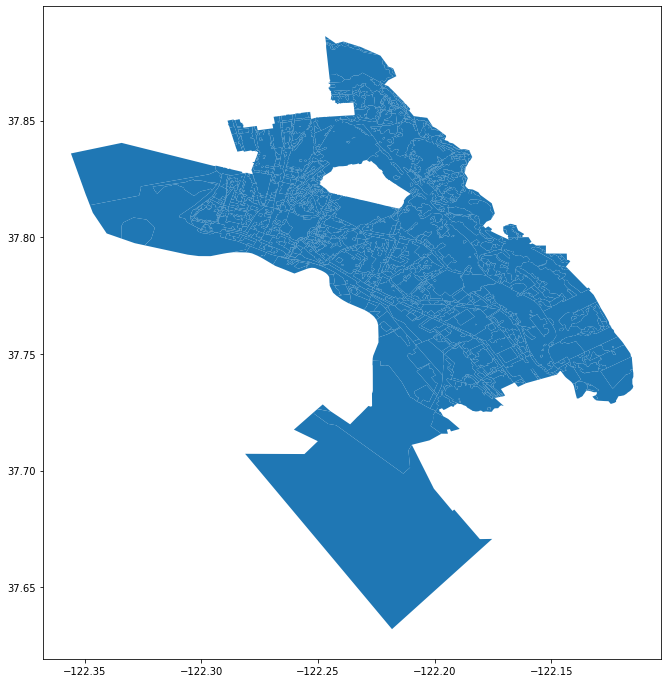

In [178]:
fig, ax = plt.subplots(figsize = (12,12))
oakl.plot(ax = ax)

### Plotting black carbon data and location of all near-by sources

##### Handles for City Name and Traffic Intersections


In [179]:
maroon_x = mlines.Line2D([], [], color='maroon', marker='x', linestyle='None',
                          markersize=6, label='Alameda')
orange_x = mlines.Line2D([], [], color='darkorange', marker='x', linestyle='None',
                          markersize=6, label='Berkeley')
yellow_x = mlines.Line2D([], [], color='lemonchiffon', marker='x', linestyle='None',
                          markersize=6, label='Oakland')
green_x = mlines.Line2D([], [], color='limegreen', marker='x', linestyle='None',
                          markersize=6, label='Piedmont')
blue_x = mlines.Line2D([], [], color='slateblue', marker='x', linestyle='None',
                          markersize=6, label='San Leandro')

fuchsia_o = mlines.Line2D([], [], color='fuchsia', marker='o', linestyle='None',
                          markersize=6, label='Traffic ')


##### Handles for facility types

maroon_D = mlines.Line2D([], [], color='maroon', marker='D', linestyle='None',
                          markersize=6, label='Airport')
orange_D = mlines.Line2D([], [], color='darkorange', marker='D', linestyle='None',
                          markersize=6, label='Auto-Body-Painting-or-Repair-Shop')
yellow_D = mlines.Line2D([], [], color='lemonchiffon', marker='D', linestyle='None',
                          markersize=6, label='Bakeries')
darkviolet_D = mlines.Line2D([], [], color='darkviolet', marker='D', linestyle='None',
                          markersize=6, label='Breweries-Distilleries-Wineries')
green_D = mlines.Line2D([], [], color='limegreen', marker='D', linestyle='None',
                          markersize=6, label='Concrete-Batch-Plant')
blue_D = mlines.Line2D([], [], color='blue', marker='D', linestyle='None',
                          markersize=6, label='Concrete-Block-Pipe-or-Other-Manuf')
fuchsia_D = mlines.Line2D([], [], color='fuchsia', marker='D', linestyle='None',
                          markersize=6, label='Crematory-Human ')
black_D = mlines.Line2D([], [], color = 'black', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Dry-Cleaner-Petroleum-Solvent')
red_D = mlines.Line2D([], [], color = 'red', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Electricity-Generation-via-Combustion')
cyan_D = mlines.Line2D([], [], color = 'cyan', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Fiberglass-Products-Manuf')
peru_D = mlines.Line2D([], [], color = 'peru', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Food-Products-Processing-Plant')
palegreen_D = mlines.Line2D([], [], color = 'palegreen', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Foundries-Iron-and-Steel')
pink_D = mlines.Line2D([], [], color = 'pink', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Hot-Mix-Asphalt-Plant')
dimgrey_D = mlines.Line2D([], [], color = 'dimgrey', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Institution')
gold_D = mlines.Line2D([], [], color = 'gold', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Landfill')
dodgerblue_D = mlines.Line2D([], [], color = 'dodgerblue', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Pharmaceutical-Manufacturing')
forestgreen_D = mlines.Line2D([], [], color = 'forestgreen', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Unknown')
slateblue_D = mlines.Line2D([], [], color = 'slateblue', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Wastewater-Treatment-Facility')

keys = set(keys)
keys = sorted(keys)
list(keys)
custom_colors = ['maroon', 'darkorange', 'lemonchiffon', 'darkviolet', 'limegreen', 'blue', 'fuchsia','black','red',
                 'cyan','peru','palegreen','pink','dimgrey','gold','dodgerblue','forestgreen','slateblue']

color_dict = dict(zip(keys, custom_colors))

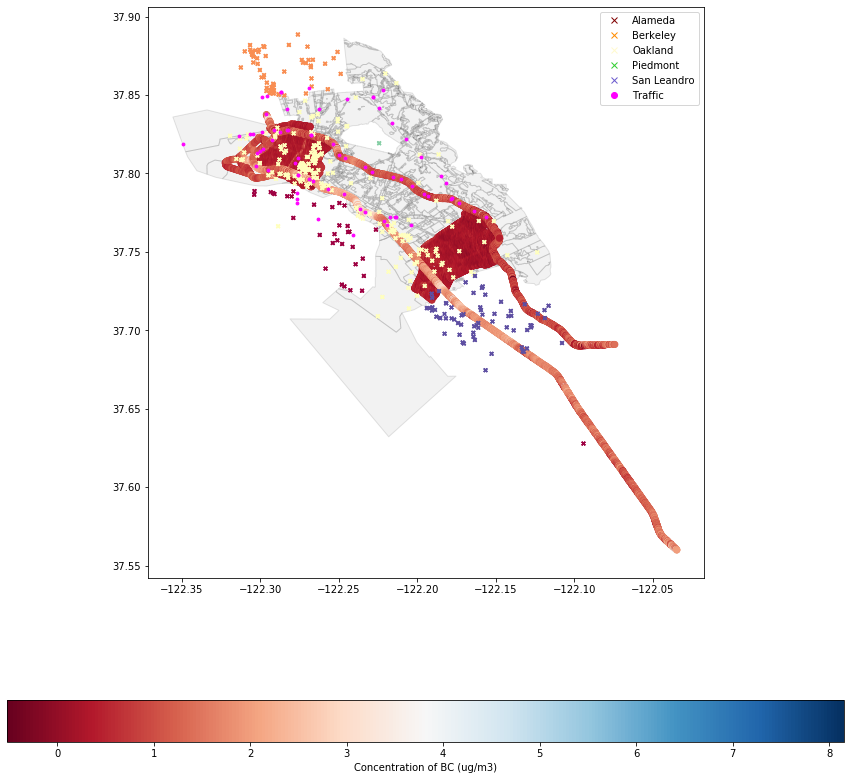

In [180]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['BC Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['BC Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.32,-122.25])
#plt.ylim([37.76,37.9])
#plt.ylim([37.8,37.82])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of BC (ug/m3)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x, fuchsia_o])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

#### Plotting NOx data and location of all near-by sources

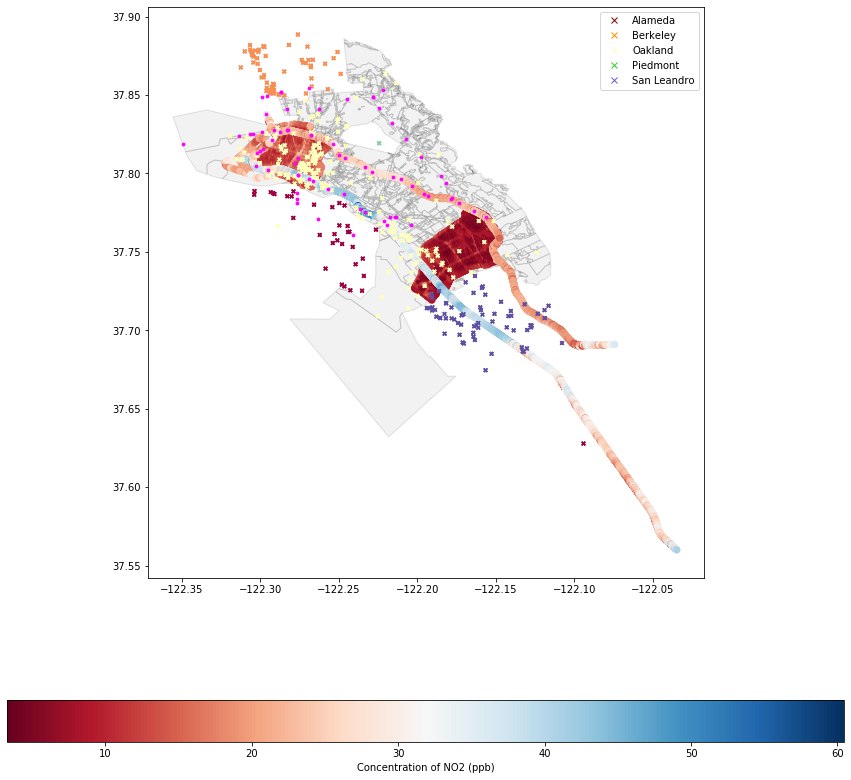

In [181]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['NO2 Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['NO2 Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'NO2 Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.25,-122.15])
#plt.ylim([37.7,37.9])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of NO2 (ppb)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

## Creating input dataframe - Method 1: 
### Here I find the nearest facility or traffic intersection to each point in the EDF data. The corresponding BC/NOx values or AADT values will be included as an addiitonal column. 

### Find Closest Facility and Traffic Intersection to each point in the EDF data

#### Unary Union of the geo_df geometry - Closest Facility

pts = geo_df_facility_PM.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_facility_PM.geometry == nearest_points(point, pts)[1]
     return geo_df_facility_PM[nearest]['eis facility id'].to_numpy()[0]
geo_df_BC['Nearest_Facility'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

#### Unary Union of the geo_df geometry - Closest Traffic Intersection

pts = geo_df_traffic.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_traffic.geometry == nearest_points(point, pts)[1]
     return geo_df_traffic[nearest]['Description'].to_numpy()[0]
geo_df_BC['Nearest_Traffic'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

#### Merge df_BC with Oak_PM on Facility ID
df_BC_merge = pd.merge(left=df_BC, right=Oak_PM, left_on='Nearest_Facility', right_on='eis facility id')

#### Merge above dataframe with traffic
df_BC_merge_traffic = pd.merge(left=df_BC_merge, right=traffic, left_on='Nearest_Traffic', right_on='Description')

df_BC_merge_traffic.head()

df_BC_merge_traffic.rename(columns={'Latitude_x':'Latitude_Conc','Longitude_x':'Longitude_Conc','latitude':'Latitude_Fac','longitude':'Longitude_Fac','Latitude_y':'Latitude_Traf','Longitude_y':'Longitude_Traf'}, inplace=True)

df_BC_merge_traffic.head()

df_BC_merge_traffic.columns

#### Create an empty list call dist which stores all the distances between each point (facility and traffic)
dist_fac = []
dist_traf = []

### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

for row in df_BC_merge_traffic.iterrows():
    dist_fac.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Fac'], row[1]['Longitude_Fac'])))
    dist_traf.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Traf'], row[1]['Longitude_Traf'])))

df_BC_merge_traffic['Dist_Facility_mi'] = np.array(dist_fac)*0.621
df_BC_merge_traffic['Dist_Traffic_mi'] = np.array(dist_traf)*0.621

#### Drop columns from df_BC_merge that are not needed anymore
df_BC_merge_traffic.drop(columns = ['eis facility id','company name_x','city','units', 'Description', 'Nearest_Traffic'], inplace=True)

#### Rename columns
df_BC_merge_traffic.rename(columns = {'geometry_x':'Conc_geo', 'geometry_y':'Fac_geo','geometry':'Traf_geo'}, inplace=True)

df_BC_merge_traffic.head()

## Creating input dataframe - Method 2: 
#### In this approach, distance to each individual industry from the point of measurement, and the corresponding PM10 and PM2.5 emissions are indivudial features. Looking at the map further, industrial sources in Oakland, Piedmont and Alameda are closest to the measurement points. We filter out all other industrial sources. 

### Combining Air Pollution Monitoring Data and Facility level data

In [ ]:
Facility_PM_All = Facility_PM.copy()

In [ ]:
Facility_PM = Facility_PM[(Facility_PM['city'] == 'OAKLAND') | (Facility_PM['city'] == 'SAN LEANDRO') | (Facility_PM['city'] == 'ALAMEDA')]

In [ ]:
Facility_PM.shape

In [ ]:
Facility_PM.describe()

In [ ]:
Facility_PM.head()

#### Looking at the basic statistics of the emissions, we can filter out the rows below the 2nd quartile as the emissions are very low.  Typically, sources with more than 1 ton of annual emissions are considered as major sources, sources below this are typically considered a minor source. 

In [ ]:
lower, upper = Facility_PM.PM10.quantile([0.5,1])
Facility_PM = Facility_PM.query('{low}<PM10<{high}'.format(low=lower,high=upper))

In [ ]:
Facility_PM.head()

In [ ]:
### Add an empty column for distance
Facility_PM['dist'] = 0
Facility_PM['dist'].astype(float)

#### Write into a csv file
Facility_PM.to_csv("Data/Facility_PM.csv")

#### We need to fill in the unknown categories for source-categories. I manually updated the source-type for most of the unknowns either based on the company name, or based on the location. The 'Facility_PM_updated' file is stored in the Data folder and is loaded here as Facility_PM. There are still 5-6 unknown sources in the dataframe. 


In [182]:
Facility_PM = pd.read_csv("Data/Facility_PM_updated.csv")

In [183]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(Facility_PM['longitude'], Facility_PM['latitude'])]

In [184]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(Facility_PM, crs = crs, geometry = geometry_facility)

#### Plotting only industrial facilities in the area

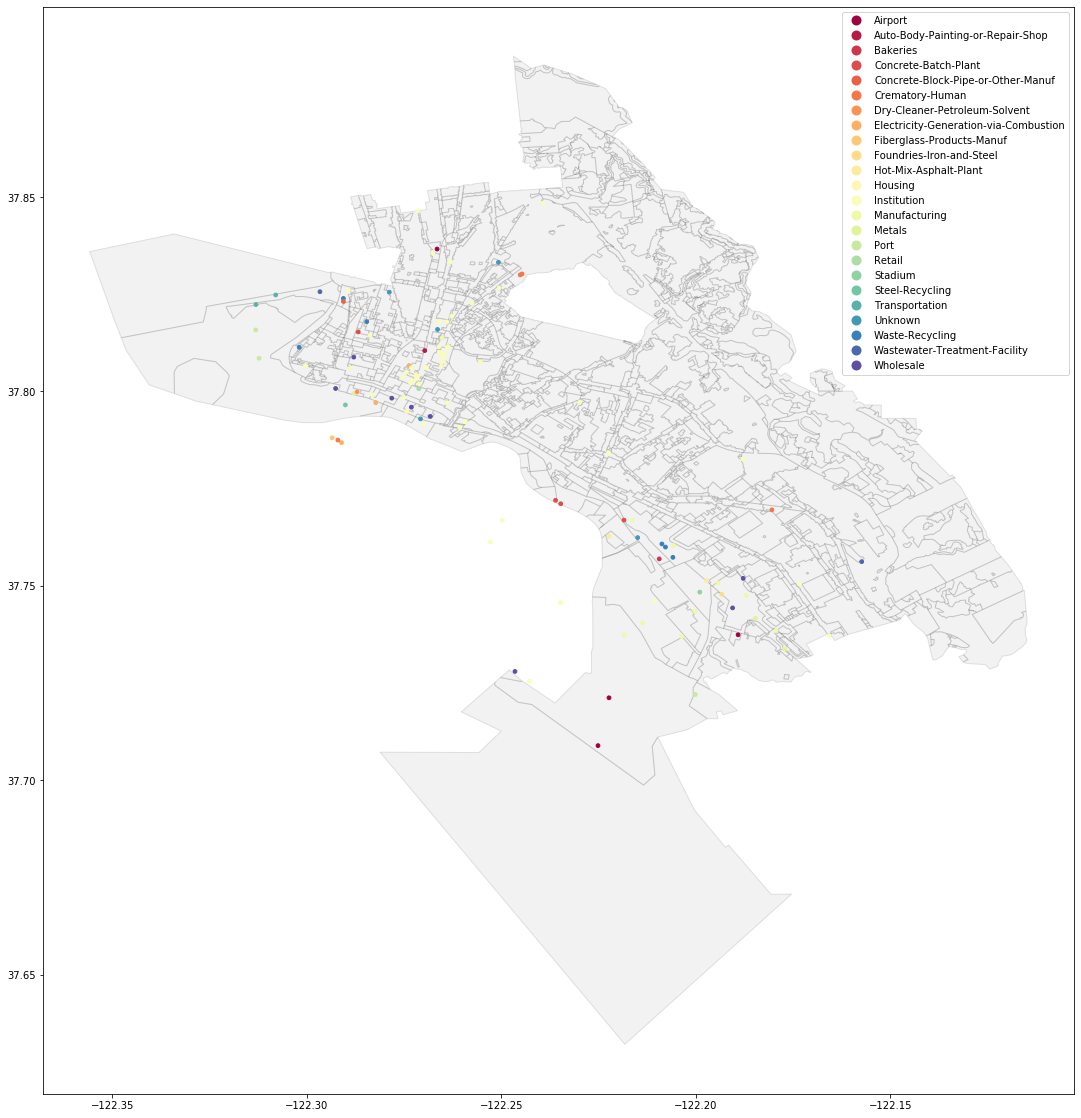

In [185]:
fig, ax = plt.subplots(figsize = (20,20)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility.plot(ax=ax, cmap = 'Spectral', column = 'source-category', legend = True, markersize = 14)
#plt.legend(handles=[maroon_D, orange_D, yellow_D, darkviolet_D ,green_D, blue_D, fuchsia_D, black_D, red_D,cyan_D,
#                   peru_D, palegreen_D, pink_D, dimgrey_D, gold_D, dodgerblue_D, forestgreen_D, slateblue_D])

plt.show()

#### Create a dataframe where each column is one of the industrial facilities, with columns as latitude, longitude, PM2.5 PM10 emissions value and geometry. 

In [ ]:
Oak_PM_lat = Facility_PM[['eis facility id', 'latitude']]
Oak_PM_long = Facility_PM[['eis facility id', 'longitude']]
Oak_PM_PM25 = Facility_PM[['eis facility id', 'PM25']]
Oak_PM_PM10 = Facility_PM[['eis facility id', 'PM10']]
Oak_PM_dist = Facility_PM[['eis facility id', 'dist']]
Oak_PM_geo = Facility_PM[['eis facility id', 'geometry']]


In [ ]:
# Transpose all the dataframes
Oak_PM_lat = Oak_PM_lat.T
Oak_PM_long = Oak_PM_long.T
Oak_PM_PM25 = Oak_PM_PM25.T
Oak_PM_PM10 = Oak_PM_PM10.T
Oak_PM_dist = Oak_PM_dist.T
Oak_PM_geo = Oak_PM_geo.T

In [ ]:
## Make the header as the first row in each transposed dataframe
Oak_PM_lat = Oak_PM_lat.rename(columns=Oak_PM_lat.iloc[0].astype(int)).drop(Oak_PM_lat.index[0])
Oak_PM_long = Oak_PM_long.rename(columns=Oak_PM_long.iloc[0].astype(int)).drop(Oak_PM_long.index[0])
Oak_PM_PM25 = Oak_PM_PM25.rename(columns=Oak_PM_PM25.iloc[0].astype(int)).drop(Oak_PM_PM25.index[0])
Oak_PM_PM10 = Oak_PM_PM10.rename(columns=Oak_PM_PM10.iloc[0].astype(int)).drop(Oak_PM_PM10.index[0])
Oak_PM_dist = Oak_PM_dist.rename(columns=Oak_PM_dist.iloc[0].astype(int)).drop(Oak_PM_dist.index[0])
Oak_PM_geo = Oak_PM_geo.rename(columns=Oak_PM_geo.iloc[0].astype(int)).drop(Oak_PM_geo.index[0])

In [ ]:
## Add suffix to column header based on the dataframe type
Oak_PM_lat.columns = [str(col) + '_latitude' for col in Oak_PM_lat.columns]
Oak_PM_long.columns = [str(col) + '_longitude' for col in Oak_PM_long.columns]
Oak_PM_PM25.columns = [str(col) + '_PM25' for col in Oak_PM_PM25.columns]
Oak_PM_PM10.columns = [str(col) + '_PM10' for col in Oak_PM_PM10.columns]
Oak_PM_dist.columns = [str(col) + '_dist' for col in Oak_PM_dist.columns]
Oak_PM_geo.columns = [str(col) + '_geo' for col in Oak_PM_geo.columns]

In [ ]:
## Remove index for each dataframe
Oak_PM_lat.reset_index(drop=True, inplace=True)
Oak_PM_long.reset_index(drop=True, inplace=True)
Oak_PM_PM25.reset_index(drop=True, inplace=True)
Oak_PM_PM10.reset_index(drop=True, inplace=True)
Oak_PM_dist.reset_index(drop=True, inplace=True)
Oak_PM_geo.reset_index(drop=True, inplace=True)

In [ ]:
Oak_PM_combined = Oak_PM_lat.join(Oak_PM_long).join(Oak_PM_PM25).join(Oak_PM_PM10).join(Oak_PM_dist).join(Oak_PM_geo)


In [ ]:
Oak_PM_combined

In [ ]:
Oak_PM_combined = Oak_PM_combined.reindex(columns=sorted(Oak_PM_combined.columns))

In [ ]:
Oak_PM_combined

In [ ]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
Oak_PM_combined = Oak_PM_combined.loc[Oak_PM_combined.index.repeat(21488)].reset_index(drop=True)

In [ ]:
BC_Facility = BC_df.join(Oak_PM_combined)

In [ ]:
# Convert distance column to float type
for idx, col in enumerate(BC_Facility.columns):
        if "_dist" in col:
            BC_Facility[col] = pd.to_numeric(BC_Facility[col], downcast="float")


### Calculate distance between point of measurement and each facility and add it to the _dist column

In [ ]:
### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [ ]:
BC_Facility.head()

### Calculating distance between each industrial facility and the point of measurement. 


##### The first method I tried was to iterate through all the columns, identify the columns with "_dist" as suffix, then iterate through rows to calcualte distance using the dist function. But this method took 47 seconds just for 1,000 rows. 

In [ ]:
time3 = time.time()
for idx, col in enumerate(BC_Facility.columns):
    if "_dist" in col:
        for index, row in BC_Facility.head(1000).iterrows():
            BC_Facility.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+2], row.iloc[idx+3])))*0.621
time4 = time.time()

print(time4 - time3)

##### In the second method, I iterate through all rows, identify the rows with "_dist" as column headers, and then calculate distance using distance function

In [ ]:
time1 = time.time()
for index, row in BC_Facility.iterrows():
    for idx, col in enumerate(BC_Facility.columns):
        if "_dist" in col:
            BC_Facility.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+2], row.iloc[idx+3])))*0.621
            #BC_Facility.at[index,col] = float(row.iloc[idx])
time2 = time.time()            
    
print(time2 - time1)


In [ ]:
BC_Facility.tail()

### Write this to a dataframe
BC_Facility.to_csv("Data/BC_Facility.csv")

##### Drop latitude, longitude and emissions since we don't need those columns. Latitude and longitude values are captured in the distance column. Since all the emissions values are the same, that feature would not be important

In [ ]:
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_PM10', case=False)] 
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_PM25', case=False)] 
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_latitude', case=False)]
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_longitude', case=False)] 

In [ ]:
BC_Facility.head()

#### Write the trimmed dataframe to a csv file
BC_Facility.to_csv("Data/BC_Facility_Trimmed.csv")

In [186]:
BC_Facility = pd.read_csv("Data/BC_Facility_Trimmed.csv")

In [187]:
BC_Facility.head()

Unnamed: 0   Longitude   Latitude  BC Value       TimePeriod  \
0           0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1           1 -122.322310  37.806150  0.551475  Jun2015-May2016   
2           2 -122.322301  37.806420  0.593712  Jun2015-May2016   
3           3 -122.322299  37.805880  0.489898  Jun2015-May2016   
4           4 -122.322267  37.806689  0.739341  Jun2015-May2016   

                                 geometry  10452911_dist  \
0        POINT (-122.3225938 37.80678062)       6.386582   
1          POINT (-122.32231 37.80614989)       6.346233   
2        POINT (-122.3223008 37.80642014)       6.358146   
3  POINT (-122.3222988 37.80587979999999)       6.333521   
4        POINT (-122.3222671 37.80668898)       6.369023   

                  10452911_geo  10457011_dist                10457011_geo  \
0  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
2  POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   
3  POINT (-122.23476 37.74567)       9.362026  POINT (-122.17711 37.7337)   
4  POINT (-122.23476 37.74567)       9.390396  POINT (-122.17711 37.7337)   

   ...  771711_dist                     771711_geo  772011_dist  \
0  ...     7.073346  POINT (-122.209381 37.756914)     2.298349   
1  ...     7.038703  POINT (-122.209381 37.756914)     2.271180   
2  ...     7.047287  POINT (-122.209381 37.756914)     2.275900   
3  ...     7.029188  POINT (-122.209381 37.756914)     2.265535   
4  ...     7.054695  POINT (-122.209381 37.756914)     2.279456   

                   772011_geo  773811_dist                   773811_geo  \
0  POINT (-122.28229 37.7971)     7.441341  POINT (-122.21835 37.73733)   
1  POINT (-122.28229 37.7971)     7.401484  POINT (-122.21835 37.73733)   
2  POINT (-122.28229 37.7971)     7.413087  POINT (-122.21835 37.73733)   
3  POINT (-122.28229 37.7971)     7.389062  POINT (-122.21835 37.73733)   
4  POINT (-122.28229 37.7971)     7.423634  POINT (-122.21835 37.73733)   

   7845711_dist                  7845711_geo  808811_dist  \
0      4.517235  POINT (-122.24515 37.82995)     3.103170   
1      4.518436  POINT (-122.24515 37.82995)     3.075784   
2      4.511207  POINT (-122.24515 37.82995)     3.080629   
3      4.524693  POINT (-122.24515 37.82995)     3.069979   
4      4.502830  POINT (-122.24515 37.82995)     3.084273   

                    808811_geo  
0  POINT (-122.26824 37.79355)  
1  POINT (-122.26824 37.79355)  
2  POINT (-122.26824 37.79355)  
3  POINT (-122.26824 37.79355)  
4  POINT (-122.26824 37.79355)  

[5 rows x 238 columns]

### Combining Air Pollution Monitoring Data, Facility level data and traffic data

#### Create a dataframe where each column is one of the traffic intersections, with columns as latitude, longitude, AADT and geometry. 

In [188]:
traffic.head()

Description    AADT   Latitude   Longitude  \
0        ALAMEDA, BROADWAY/ ENCINAL AVENUE    8700  37.760576 -122.240708   
1  ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET    9500  37.770910 -122.263477   
3                   OAKLAND, JCT. RTE. 880   22900  37.769397 -122.221166   
4                OAKLAND, EAST 12TH STREET   16400  37.772068 -122.217378   
6        SAN FRANCISCO/ALAMEDA COUNTY LINE  278000  37.818854 -122.349603   

                      geometry  
0  POINT (-122.24071 37.76058)  
1  POINT (-122.26348 37.77091)  
3  POINT (-122.22117 37.76940)  
4  POINT (-122.21738 37.77207)  
6  POINT (-122.34960 37.81885)

In [189]:
## Assign an intersection number to each traffic intersection instead of using description
traffic.reset_index(inplace=True)

In [190]:
#Rename index as Intersection
traffic.rename(columns={"index":"Intersection"}, inplace=True)

In [191]:
#Drop the description column
traffic.drop(columns=['Description'], inplace=True)

In [192]:
### Add an empty column for distance
traffic['dist'] = 0
traffic['dist'].astype(float)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
66    0.0
67    0.0
68    0.0
69    0.0
70    0.0
Name: dist, Length: 71, dtype: float64

In [193]:
traffic_lat = traffic[['Intersection', 'Latitude']].T
traffic_long = traffic[['Intersection', 'Longitude']].T
traffic_AADT = traffic[['Intersection', 'AADT']].T
traffic_dist = traffic[['Intersection', 'dist']].T
traffic_geo = traffic[['Intersection', 'geometry']].T


In [194]:
traffic_lat.head()

0         1          2          3          4          5   \
Intersection   0.000000   1.00000   3.000000   4.000000   6.000000   7.000000   
Latitude      37.760576  37.77091  37.769397  37.772068  37.818854  37.823843   

                     6        7          8          9   ...         61  \
Intersection   8.000000   9.0000  10.000000  11.000000  ...  79.000000   
Latitude      37.824855  37.8252  37.826401  37.837849  ...  37.796197   

                     62         63         64         65         66  \
Intersection  80.000000  81.000000  82.000000  83.000000  84.000000   
Latitude      37.799155  37.802161  37.804525  37.813292  37.815518   

                     67         68        69        70  
Intersection  85.000000  91.000000  92.00000  93.00000  
Latitude      37.821345  37.799143  37.80688  37.80949  

[2 rows x 71 columns]

In [195]:
## Make the header as the first row in each transposed dataframe
traffic_lat = traffic_lat.rename(columns=traffic_lat.iloc[0].astype(int)).drop(traffic_lat.index[0])
traffic_long = traffic_long.rename(columns=traffic_long.iloc[0].astype(int)).drop(traffic_long.index[0])
traffic_AADT = traffic_AADT.rename(columns=traffic_AADT.iloc[0].astype(int)).drop(traffic_AADT.index[0])
traffic_dist = traffic_dist.rename(columns=traffic_dist.iloc[0].astype(int)).drop(traffic_dist.index[0])
traffic_geo = traffic_geo.rename(columns=traffic_geo.iloc[0].astype(int)).drop(traffic_geo.index[0])

In [196]:
## Add suffix to column header based on the dataframe type
traffic_lat.columns = [str(col) + '_latitude' for col in traffic_lat.columns]
traffic_long.columns = [str(col) + '_longitude' for col in traffic_long.columns]
traffic_AADT.columns = [str(col) + '_AADT' for col in traffic_AADT.columns]
traffic_dist.columns = [str(col) + '_traf_dist' for col in traffic_dist.columns]
traffic_geo.columns = [str(col) + '_geo' for col in traffic_geo.columns]

In [197]:
## Remove index for each dataframe
traffic_lat.reset_index(drop=True, inplace=True)
traffic_long.reset_index(drop=True, inplace=True)
traffic_AADT.reset_index(drop=True, inplace=True)
traffic_dist.reset_index(drop=True, inplace=True)
traffic_geo.reset_index(drop=True, inplace=True)

In [198]:
traffic_combined = traffic_lat.join(traffic_long).join(traffic_AADT).join(traffic_dist).join(traffic_geo)


In [199]:
traffic_combined

0_latitude  1_latitude  3_latitude  4_latitude  6_latitude  7_latitude  \
0   37.760576    37.77091   37.769397   37.772068   37.818854   37.823843   

   8_latitude  9_latitude  10_latitude  11_latitude  ...  \
0   37.824855     37.8252    37.826401    37.837849  ...   

                                 79_geo                                80_geo  \
0  POINT (-122.268861055 37.7961974865)  POINT (-122.276314697 37.7991552558)   

                                 81_geo                               82_geo  \
0  POINT (-122.295484996 37.8021614459)  POINT (-122.30272491 37.8045252655)   

                                 83_geo                                84_geo  \
0  POINT (-122.302016965 37.8132921671)  POINT (-122.298635478 37.8155178024)   

                                85_geo                               91_geo  \
0  POINT (-122.292823965 37.821344812)  POINT (-122.276152929 37.799143267)   

                            92_geo                           93_geo  
0  POINT (-122.277795333 37.80688)  POINT (-122.276034999 37.80949)  

[1 rows x 355 columns]

In [200]:
traffic_combined = traffic_combined.reindex(columns=sorted(traffic_combined.columns))

In [201]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
traffic_combined = traffic_combined.loc[traffic_combined.index.repeat(21488)].reset_index(drop=True)

In [202]:
BC_Facility_Traffic = BC_Facility.join(traffic_combined)

In [203]:
BC_Facility_Traffic.head()

Unnamed: 0   Longitude   Latitude  BC Value       TimePeriod  \
0           0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1           1 -122.322310  37.806150  0.551475  Jun2015-May2016   
2           2 -122.322301  37.806420  0.593712  Jun2015-May2016   
3           3 -122.322299  37.805880  0.489898  Jun2015-May2016   
4           4 -122.322267  37.806689  0.739341  Jun2015-May2016   

                                 geometry  10452911_dist  \
0        POINT (-122.3225938 37.80678062)       6.386582   
1          POINT (-122.32231 37.80614989)       6.346233   
2        POINT (-122.3223008 37.80642014)       6.358146   
3  POINT (-122.3222988 37.80587979999999)       6.333521   
4        POINT (-122.3222671 37.80668898)       6.369023   

                  10452911_geo  10457011_dist                10457011_geo  \
0  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
2  POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   
3  POINT (-122.23476 37.74567)       9.362026  POINT (-122.17711 37.7337)   
4  POINT (-122.23476 37.74567)       9.390396  POINT (-122.17711 37.7337)   

   ...  93_AADT                           93_geo  93_latitude 93_longitude  \
0  ...   140700  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
1  ...   140700  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
2  ...   140700  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
3  ...   140700  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
4  ...   140700  POINT (-122.276034999 37.80949)     37.80949  -122.276035   

   93_traf_dist  9_AADT                                9_geo 9_latitude  \
0             0  157500  POINT (-122.304611578 37.825200142)    37.8252   
1             0  157500  POINT (-122.304611578 37.825200142)    37.8252   
2             0  157500  POINT (-122.304611578 37.825200142)    37.8252   
3             0  157500  POINT (-122.304611578 37.825200142)    37.8252   
4             0  157500  POINT (-122.304611578 37.825200142)    37.8252   

   9_longitude 9_traf_dist  
0  -122.304612           0  
1  -122.304612           0  
2  -122.304612           0  
3  -122.304612           0  
4  -122.304612           0  

[5 rows x 593 columns]

In [204]:
BC_Facility_Traffic.drop(BC_Facility_Traffic.columns[[0]], axis=1, inplace=True)

In [205]:
BC_Facility_Traffic.head(50)

Longitude   Latitude  BC Value       TimePeriod  \
0  -122.322594  37.806781  0.818032  Jun2015-May2016   
1  -122.322310  37.806150  0.551475  Jun2015-May2016   
2  -122.322301  37.806420  0.593712  Jun2015-May2016   
3  -122.322299  37.805880  0.489898  Jun2015-May2016   
4  -122.322267  37.806689  0.739341  Jun2015-May2016   
5  -122.322262  37.806720  0.701457  Jun2015-May2016   
6  -122.322251  37.805613  0.377171  Jun2015-May2016   
7  -122.322209  37.805475  0.562943  Jun2015-May2016   
8  -122.322196  37.806907  0.538130  Jun2015-May2016   
9  -122.322146  37.805356  0.753676  Jun2015-May2016   
10 -122.322069  37.807157  0.707618  Jun2015-May2016   
11 -122.322006  37.805109  0.743399  Jun2015-May2016   
12 -122.321904  37.807393  0.756182  Jun2015-May2016   
13 -122.321831  37.804878  0.686764  Jun2015-May2016   
14 -122.321700  37.807609  0.860256  Jun2015-May2016   
15 -122.321628  37.804660  0.712646  Jun2015-May2016   
16 -122.321456  37.807798  1.093568  Jun2015-May2016   
17 -122.321389  37.804468  0.570328  Jun2015-May2016   
18 -122.321176  37.807951  1.136298  Jun2015-May2016   
19 -122.321127  37.804296  0.438949  Jun2015-May2016   
20 -122.320871  37.808070  1.232716  Jun2015-May2016   
21 -122.320836  37.804155  0.426396  Jun2015-May2016   
22 -122.320550  37.808162  0.949938  Jun2015-May2016   
23 -122.320531  37.804035  0.621131  Jun2015-May2016   
24 -122.320228  37.808251  1.102852  Jun2015-May2016   
25 -122.320217  37.803930  0.647189  Jun2015-May2016   
26 -122.319906  37.808339  1.015156  Jun2015-May2016   
27 -122.319902  37.803828  0.618309  Jun2015-May2016   
28 -122.319586  37.803725  0.636180  Jun2015-May2016   
29 -122.319584  37.808427  0.898645  Jun2015-May2016   
30 -122.319271  37.803622  0.583947  Jun2015-May2016   
31 -122.319262  37.808515  0.943403  Jun2015-May2016   
32 -122.318956  37.803520  0.655341  Jun2015-May2016   
33 -122.318940  37.808604  1.027452  Jun2015-May2016   
34 -122.318641  37.803417  0.735776  Jun2015-May2016   
35 -122.318618  37.808692  0.921008  Jun2015-May2016   
36 -122.318326  37.803314  0.894347  Jun2015-May2016   
37 -122.318296  37.808780  0.876407  Jun2015-May2016   
38 -122.318010  37.803211  0.915796  Jun2015-May2016   
39 -122.317972  37.808865  0.819667  Jun2015-May2016   
40 -122.317695  37.803109  1.073972  Jun2015-May2016   
41 -122.317640  37.808925  0.774901  Jun2015-May2016   
42 -122.317380  37.803006  0.701213  Jun2015-May2016   
43 -122.317302  37.808957  0.930495  Jun2015-May2016   
44 -122.317065  37.802903  0.656677  Jun2015-May2016   
45 -122.316961  37.808966  1.034153  Jun2015-May2016   
46 -122.316750  37.802800  0.687607  Jun2015-May2016   
47 -122.316621  37.808949  1.160115  Jun2015-May2016   
48 -122.316434  37.802697  0.783790  Jun2015-May2016   
49 -122.316282  37.808926  1.145912  Jun2015-May2016   

                                  geometry  10452911_dist  \
0         POINT (-122.3225938 37.80678062)       6.386582   
1           POINT (-122.32231 37.80614989)       6.346233   
2         POINT (-122.3223008 37.80642014)       6.358146   
3   POINT (-122.3222988 37.80587979999999)       6.333521   
4         POINT (-122.3222671 37.80668898)       6.369023   
5         POINT (-122.3222617 37.80671982)       6.370210   
6          POINT (-122.3222506 37.8056125)       6.319439   
7         POINT (-122.3222086 37.80547545)       6.311514   
8         POINT (-122.3221959 37.80690666)       6.376062   
9         POINT (-122.3221459 37.80535556)       6.303514   
10        POINT (-122.3220693 37.80715744)       6.382393   
11        POINT (-122.3220056 37.80510933)       6.286614   
12        POINT (-122.3219043 37.80739334)       6.386526   
13        POINT (-122.3218307 37.80487754)       6.268941   
14        POINT (-122.3216999 37.80760926)       6.388190   
15        POINT (-122.3216279 37.80466038)       6.250778   
16        POINT (-122.3214562 37.80779813)       6.387064   
17         POINT (-122.3213894 37.8044677)       6

In [206]:
# Convert distance column to float type
for idx, col in enumerate(BC_Facility_Traffic.columns):
        if "_traf_dist" in col:
            BC_Facility_Traffic[col] = pd.to_numeric(BC_Facility_Traffic[col], downcast="float")


#### Calculate distance between each traffic intersection and point of measurement and store this in the _dist column

In [208]:
for index, row in BC_Facility_Traffic.iterrows():
    for idx, col in enumerate(BC_Facility_Traffic.columns):
        if "_traf_dist" in col: 
            BC_Facility_Traffic.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx-2], row.iloc[idx-1])))*0.621
            #BC_Facility_Traffic.at[index,col] = float(row.iloc[idx])



In [209]:
BC_Facility_Traffic.head()

Longitude   Latitude  BC Value       TimePeriod  \
0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1 -122.322310  37.806150  0.551475  Jun2015-May2016   
2 -122.322301  37.806420  0.593712  Jun2015-May2016   
3 -122.322299  37.805880  0.489898  Jun2015-May2016   
4 -122.322267  37.806689  0.739341  Jun2015-May2016   

                                 geometry  10452911_dist  \
0        POINT (-122.3225938 37.80678062)       6.386582   
1          POINT (-122.32231 37.80614989)       6.346233   
2        POINT (-122.3223008 37.80642014)       6.358146   
3  POINT (-122.3222988 37.80587979999999)       6.333521   
4        POINT (-122.3222671 37.80668898)       6.369023   

                  10452911_geo  10457011_dist                10457011_geo  \
0  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
2  POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   
3  POINT (-122.23476 37.74567)       9.362026  POINT (-122.17711 37.7337)   
4  POINT (-122.23476 37.74567)       9.390396  POINT (-122.17711 37.7337)   

   10457511_dist  ... 93_AADT                           93_geo 93_latitude  \
0       1.995507  ...  140700  POINT (-122.276034999 37.80949)    37.80949   
1       1.970443  ...  140700  POINT (-122.276034999 37.80949)    37.80949   
2       1.974141  ...  140700  POINT (-122.276034999 37.80949)    37.80949   
3       1.965829  ...  140700  POINT (-122.276034999 37.80949)    37.80949   
4       1.976688  ...  140700  POINT (-122.276034999 37.80949)    37.80949   

   93_longitude 93_traf_dist  9_AADT                                9_geo  \
0   -122.276035     2.546934  157500  POINT (-122.304611578 37.825200142)   
1   -122.276035     2.535095  157500  POINT (-122.304611578 37.825200142)   
2   -122.276035     2.532960  157500  POINT (-122.304611578 37.825200142)   
3   -122.276035     2.536256  157500  POINT (-122.304611578 37.825200142)   
4   -122.276035     2.529637  157500  POINT (-122.304611578 37.825200142)   

   9_latitude 9_longitude  9_traf_dist  
0     37.8252 -122.304612     1.606228  
1     37.8252 -122.304612     1.631727  
2     37.8252 -122.304612     1.616419  
3     37.8252 -122.304612     1.646442  
4     37.8252 -122.304612     1.600457  

[5 rows x 592 columns]

#### Write this to a dataframe
BC_Facility_Traffic.to_csv("Data/BC_Facility_Traffic.csv")

#### Similar to the facility dataframe, drop latitude and longitude since its captured in the distance column. Also drop AADT

In [211]:
BC_Facility_Traffic.drop(list(BC_Facility_Traffic.filter(regex = '_latitude')), axis = 1, inplace = True)

In [212]:
BC_Facility_Traffic.drop(list(BC_Facility_Traffic.filter(regex = '_longitude')), axis = 1, inplace = True)

In [213]:
BC_Facility_Traffic.drop(list(BC_Facility_Traffic.filter(regex = '_AADT')), axis = 1, inplace = True)

In [214]:
BC_Facility_Traffic.head()

Longitude   Latitude  BC Value       TimePeriod  \
0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1 -122.322310  37.806150  0.551475  Jun2015-May2016   
2 -122.322301  37.806420  0.593712  Jun2015-May2016   
3 -122.322299  37.805880  0.489898  Jun2015-May2016   
4 -122.322267  37.806689  0.739341  Jun2015-May2016   

                                 geometry  10452911_dist  \
0        POINT (-122.3225938 37.80678062)       6.386582   
1          POINT (-122.32231 37.80614989)       6.346233   
2        POINT (-122.3223008 37.80642014)       6.358146   
3  POINT (-122.3222988 37.80587979999999)       6.333521   
4        POINT (-122.3222671 37.80668898)       6.369023   

                  10452911_geo  10457011_dist                10457011_geo  \
0  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
2  POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   
3  POINT (-122.23476 37.74567)       9.362026  POINT (-122.17711 37.7337)   
4  POINT (-122.23476 37.74567)       9.390396  POINT (-122.17711 37.7337)   

   10457511_dist  ...                                 8_geo  8_traf_dist  \
0       1.995507  ...  POINT (-122.306416622 37.8248552647)     1.528555   
1       1.970443  ...  POINT (-122.306416622 37.8248552647)     1.555640   
2       1.974141  ...  POINT (-122.306416622 37.8248552647)     1.539898   
3       1.965829  ...  POINT (-122.306416622 37.8248552647)     1.570824   
4       1.976688  ...  POINT (-122.306416622 37.8248552647)     1.523542   

                                91_geo  91_traf_dist  \
0  POINT (-122.276152929 37.799143267)      2.588098   
1  POINT (-122.276152929 37.799143267)      2.564378   
2  POINT (-122.276152929 37.799143267)      2.567468   
3  POINT (-122.276152929 37.799143267)      2.560329   
4  POINT (-122.276152929 37.799143267)      2.569361   

                            92_geo  92_traf_dist  \
0  POINT (-122.277795333 37.80688)      2.444070   
1  POINT (-122.277795333 37.80688)      2.429110   
2  POINT (-122.277795333 37.80688)      2.428288   
3  POINT (-122.277795333 37.80688)      2.428963   
4  POINT (-122.277795333 37.80688)      2.426274   

                            93_geo  93_traf_dist  \
0  POINT (-122.276034999 37.80949)      2.546934   
1  POINT (-122.276034999 37.80949)      2.535095   
2  POINT (-122.276034999 37.80949)      2.532960   
3  POINT (-122.276034999 37.80949)      2.536256   
4  POINT (-122.276034999 37.80949)      2.529637   

                                 9_geo  9_traf_dist  
0  POINT (-122.304611578 37.825200142)     1.606228  
1  POINT (-122.304611578 37.825200142)     1.631727  
2  POINT (-122.304611578 37.825200142)     1.616419  
3  POINT (-122.304611578 37.825200142)     1.646442  
4  POINT (-122.304611578 37.825200142)     1.600457  

[5 rows x 379 columns]

In [215]:
# Write to a dataframe
BC_Facility_Traffic.to_csv("Data/BC_Facility_Traffic_Trimmed.csv")

In [ ]:
BC_Facility_Traffic = pd.read_csv("Data/BC_Facility_Traffic_Trimmed.csv")

In [ ]:
BC_Facility_Traffic.head()

### Mapping weather data with traffic and facilities

In [216]:
met = pd.read_csv("Data/daymet_avg_15_16.csv")

In [217]:
met.drop(columns = ['Unnamed: 0'], inplace=True)

In [218]:
met.head()

Daylen    Precip   Radiation    Maxtemp    Mintemp    Pressure  \
0  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   
1  43223.606557  1.573770  344.874317  21.258197  11.527322  919.453552   
2  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   
3  43223.606557  1.573770  344.874317  21.258197  11.527322  919.453552   
4  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   

    Latitude   Longitude  
0  37.806781 -122.322594  
1  37.806781 -122.322594  
2  37.806150 -122.322310  
3  37.806150 -122.322310  
4  37.806420 -122.322301

In [219]:
BC_Facility_Traffic_Met  = pd.merge(left=BC_Facility_Traffic, right=met, left_on=['Latitude','Longitude'], right_on=['Latitude','Longitude'])

In [220]:
BC_Facility_Traffic_Met.head()

Longitude   Latitude  BC Value       TimePeriod  \
0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1 -122.322594  37.806781  0.818032  Jun2015-May2016   
2 -122.322310  37.806150  0.551475  Jun2015-May2016   
3 -122.322310  37.806150  0.551475  Jun2015-May2016   
4 -122.322301  37.806420  0.593712  Jun2015-May2016   

                           geometry  10452911_dist  \
0  POINT (-122.3225938 37.80678062)       6.386582   
1  POINT (-122.3225938 37.80678062)       6.386582   
2    POINT (-122.32231 37.80614989)       6.346233   
3    POINT (-122.32231 37.80614989)       6.346233   
4  POINT (-122.3223008 37.80642014)       6.358146   

                  10452911_geo  10457011_dist                10457011_geo  \
0  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
2  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
3  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
4  POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   

   10457511_dist  ...                           93_geo  93_traf_dist  \
0       1.995507  ...  POINT (-122.276034999 37.80949)      2.546934   
1       1.995507  ...  POINT (-122.276034999 37.80949)      2.546934   
2       1.970443  ...  POINT (-122.276034999 37.80949)      2.535095   
3       1.970443  ...  POINT (-122.276034999 37.80949)      2.535095   
4       1.974141  ...  POINT (-122.276034999 37.80949)      2.532960   

                                 9_geo  9_traf_dist        Daylen    Precip  \
0  POINT (-122.304611578 37.825200142)     1.606228  43223.606557  1.650273   
1  POINT (-122.304611578 37.825200142)     1.606228  43223.606557  1.573770   
2  POINT (-122.304611578 37.825200142)     1.631727  43223.606557  1.650273   
3  POINT (-122.304611578 37.825200142)     1.631727  43223.606557  1.573770   
4  POINT (-122.304611578 37.825200142)     1.616419  43223.606557  1.650273   

    Radiation    Maxtemp    Mintemp    Pressure  
0  341.831694  20.744536  11.528689  922.076503  
1  344.874317  21.258197  11.527322  919.453552  
2  341.831694  20.744536  11.528689  922.076503  
3  344.874317  21.258197  11.527322  919.453552  
4  341.831694  20.744536  11.528689  922.076503  

[5 rows x 385 columns]

In [221]:
## Drop day length column and write to a csv file. 
BC_Facility_Traffic_Met.drop(columns = ['Daylen'], inplace = True)

In [222]:
BC_Facility_Traffic_Met.to_csv("Data/BC_Facility_Traffic_Met.csv")

In [223]:
#### Drop _geo column and write to another csv file
BC_Facility_Traffic_Met.drop(list(BC_Facility_Traffic_Met.filter(regex = '_geo')), axis = 1, inplace = True)

In [224]:
BC_Facility_Traffic_Met.head()

Longitude   Latitude  BC Value       TimePeriod  \
0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1 -122.322594  37.806781  0.818032  Jun2015-May2016   
2 -122.322310  37.806150  0.551475  Jun2015-May2016   
3 -122.322310  37.806150  0.551475  Jun2015-May2016   
4 -122.322301  37.806420  0.593712  Jun2015-May2016   

                           geometry  10452911_dist  10457011_dist  \
0  POINT (-122.3225938 37.80678062)       6.386582       9.408835   
1  POINT (-122.3225938 37.80678062)       6.386582       9.408835   
2    POINT (-122.32231 37.80614989)       6.346233       9.372474   
3    POINT (-122.32231 37.80614989)       6.346233       9.372474   
4  POINT (-122.3223008 37.80642014)       6.358146       9.382011   

   10457511_dist  10457611_dist  10457911_dist  ...  8_traf_dist  \
0       1.995507       1.909979       6.315630  ...     1.528555   
1       1.995507       1.909979       6.315630  ...     1.528555   
2       1.970443       1.879757       6.282803  ...     1.555640   
3       1.970443       1.879757       6.282803  ...     1.555640   
4       1.974141       1.885975       6.290417  ...     1.539898   

   91_traf_dist  92_traf_dist  93_traf_dist  9_traf_dist    Precip  \
0      2.588098      2.444070      2.546934     1.606228  1.650273   
1      2.588098      2.444070      2.546934     1.606228  1.573770   
2      2.564378      2.429110      2.535095     1.631727  1.650273   
3      2.564378      2.429110      2.535095     1.631727  1.573770   
4      2.567468      2.428288      2.532960     1.616419  1.650273   

    Radiation    Maxtemp    Mintemp    Pressure  
0  341.831694  20.744536  11.528689  922.076503  
1  344.874317  21.258197  11.527322  919.453552  
2  341.831694  20.744536  11.528689  922.076503  
3  344.874317  21.258197  11.527322  919.453552  
4  341.831694  20.744536  11.528689  922.076503  

[5 rows x 197 columns]

In [225]:
# Drop column with geometry as values
BC_Facility_Traffic_Met.drop(list(BC_Facility_Traffic_Met.filter(regex = 'geometry')), axis = 1, inplace = True)

In [259]:
# Drop Latitude, longitude and time period
BC_Facility_Traffic_Met.drop(list(BC_Facility_Traffic_Met.filter(regex = 'Latitude')), axis = 1, inplace = True)
BC_Facility_Traffic_Met.drop(list(BC_Facility_Traffic_Met.filter(regex = 'Longitude')), axis = 1, inplace = True)
BC_Facility_Traffic_Met.drop(list(BC_Facility_Traffic_Met.filter(regex = 'TimePeriod')), axis = 1, inplace = True)

In [260]:
### Write to a new csv file
BC_Facility_Traffic_Met.to_csv("Data/BC_Facility_Traffic_nogeo.csv")

In [267]:
corr = BC_Facility_Traffic_Met.corr()

In [268]:
arr_corr = corr.as_matrix()

/home/shridhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [270]:
arr_corr[0]

array([ 1.        ,  0.25852493,  0.353994  , -0.3834404 , -0.39454467,
        0.34762498, -0.2918806 , -0.36229201, -0.34077851, -0.40698469,
       -0.34068377, -0.38909869,  0.27876077, -0.26765683,  0.35541866,
       -0.29826424,  0.34495308, -0.31525733,  0.32691898, -0.34522871,
        0.32583646,  0.14408695, -0.36270777, -0.29040422, -0.21730715,
       -0.33420229,  0.31162325, -0.28584566, -0.40900807, -0.28399072,
        0.23062241, -0.33496405,  0.2857321 ,  0.34125738, -0.31098529,
       -0.34177671, -0.39450998, -0.33372816,  0.357646  , -0.40923331,
        0.36007884, -0.34002904,  0.42166856,  0.37306418, -0.24624752,
       -0.34737671, -0.34054427, -0.34702437, -0.32036853,  0.36233572,
       -0.35092389, -0.34302935, -0.34620338,  0.35594597,  0.32231875,
        0.21057606,  0.36945595, -0.32156482, -0.3012656 , -0.34103782,
       -0.31230999, -0.3253045 , -0.31665077, -0.34315722, -0.31838469,
       -0.3771399 , -0.39457566, -0.33504781,  0.38830691, -0.37

#### Plotting correlation between all features as a heatmap - but this visualization is not easy to follow....

fig, ax = plt.subplots(figsize=(100, 100))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=500),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

module://ipykernel.pylab.backend_inline


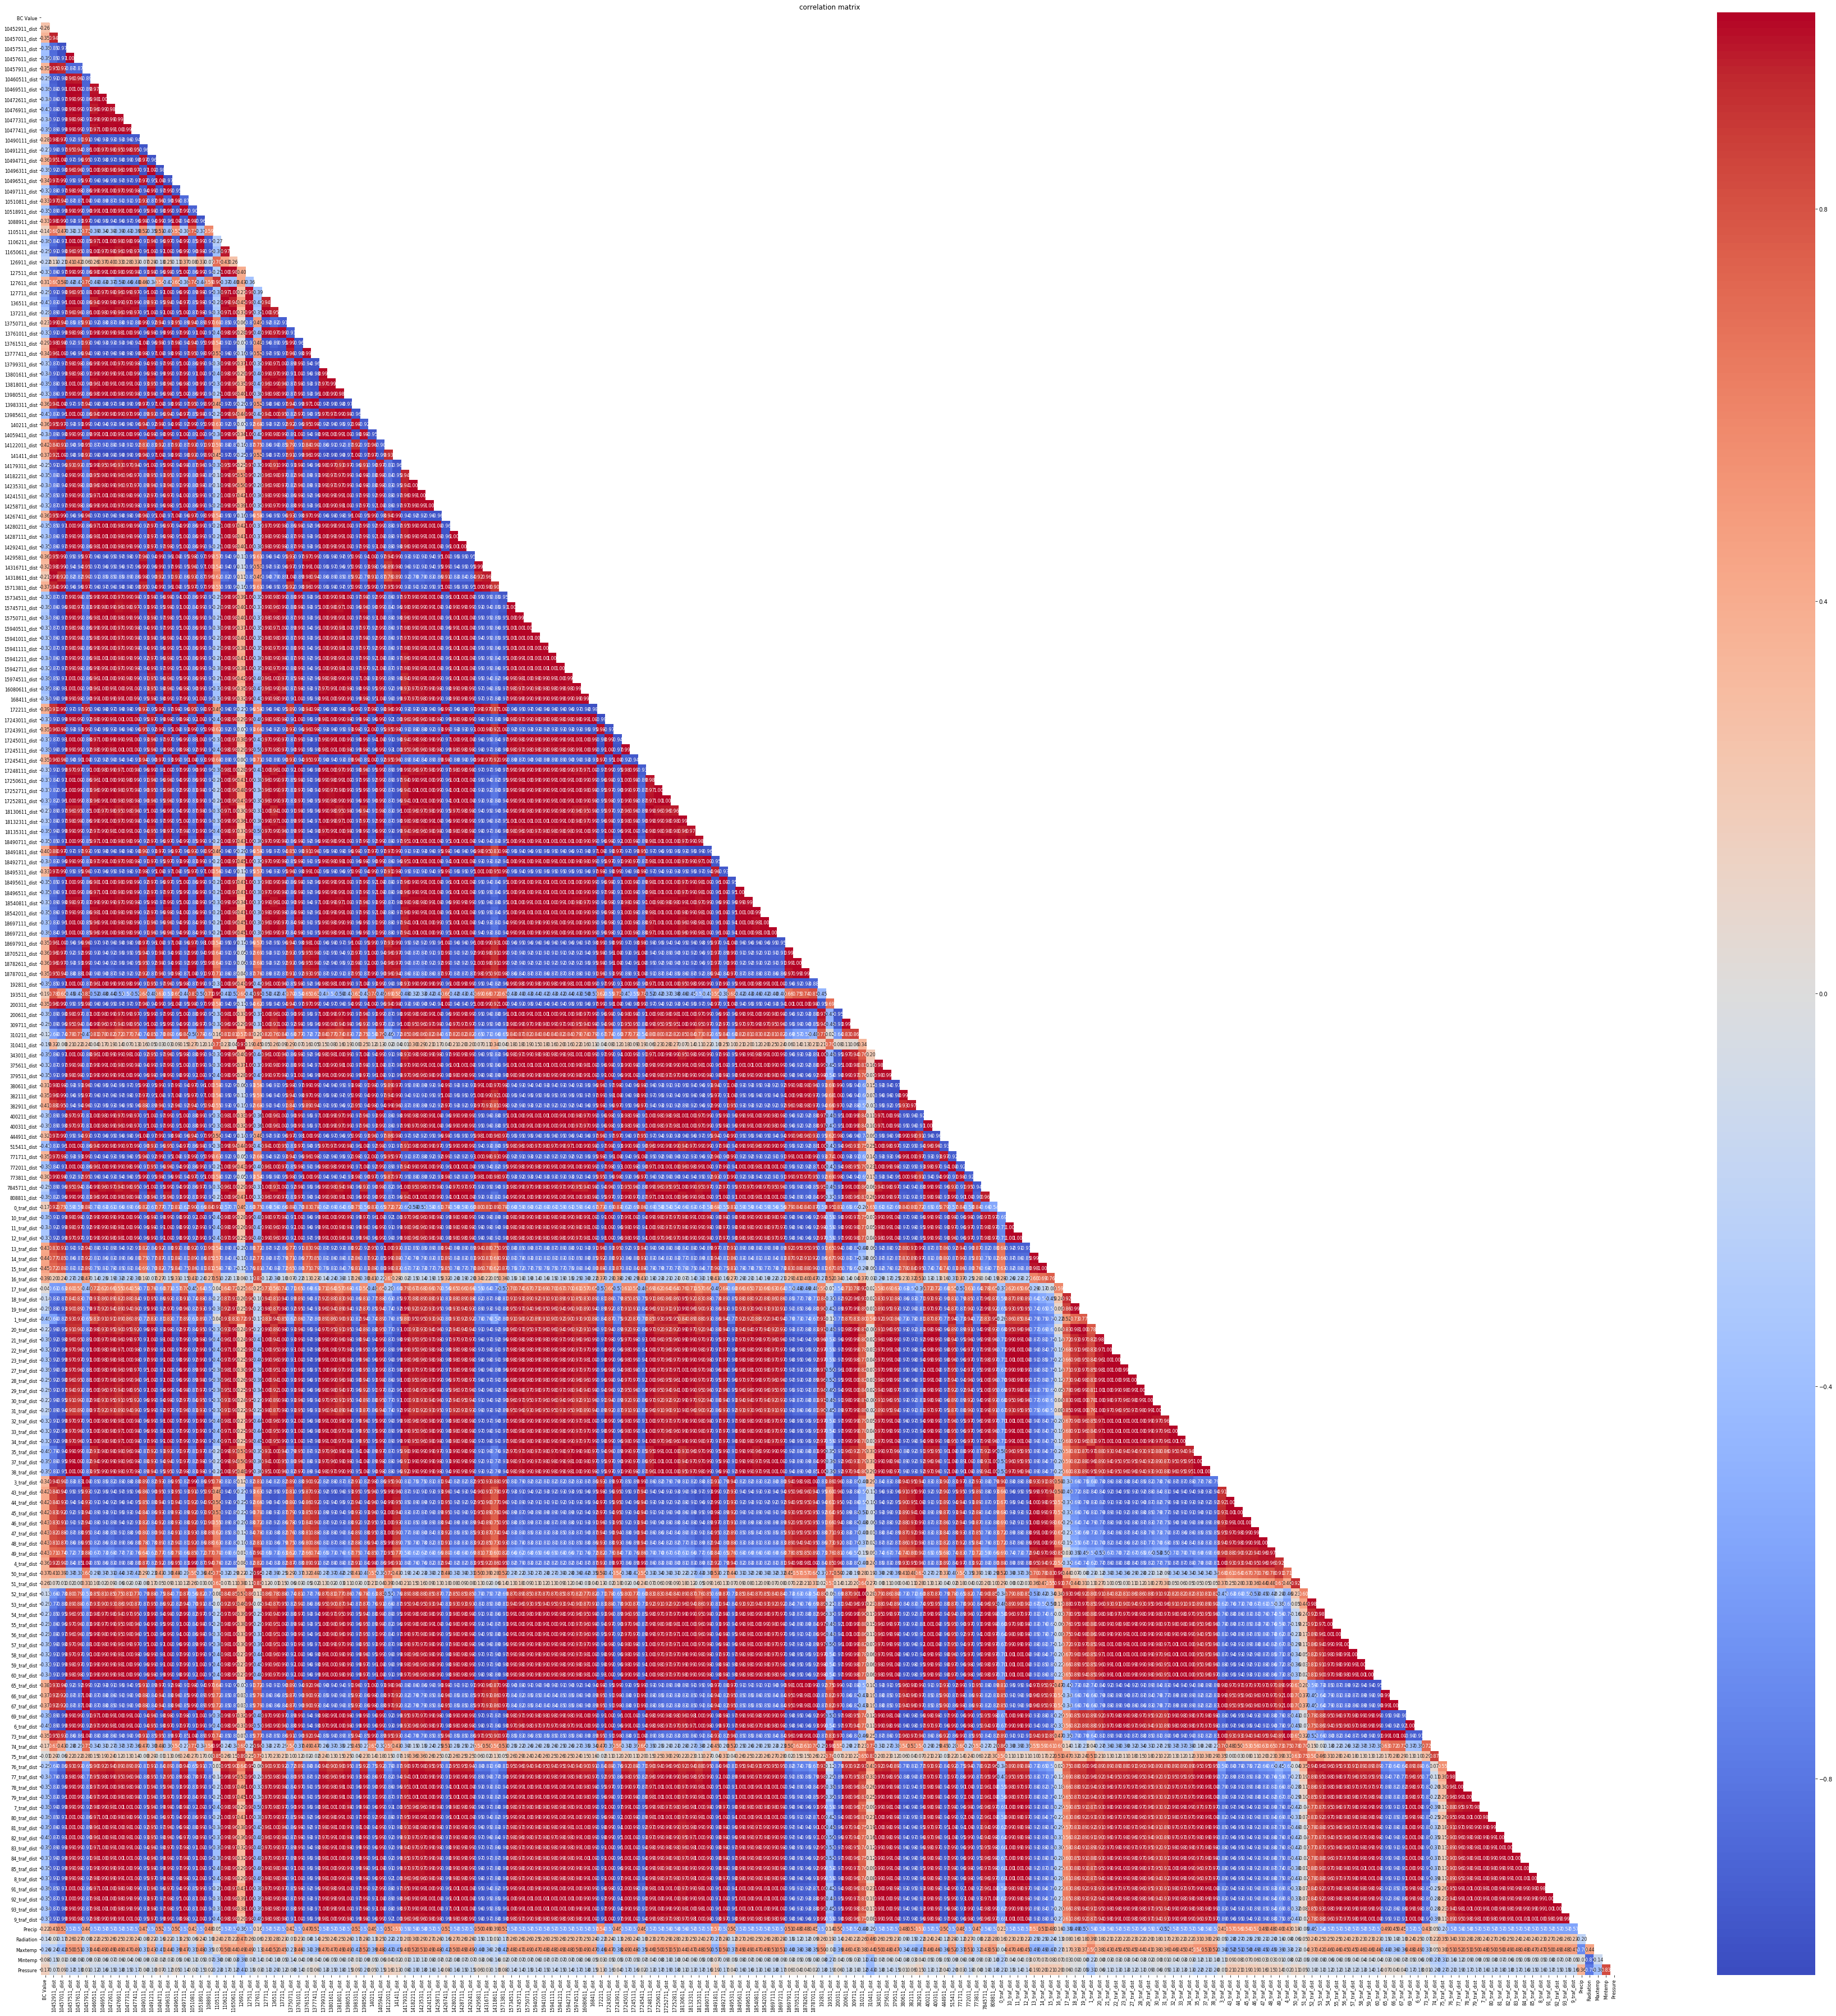

In [275]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
arr_corr[np.triu_indices_from(arr_corr)] = np.nan

fig, ax = plt.subplots(figsize=(50, 50))

hm = sns.heatmap(arr_corr, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')
#cmap=plt.cm.Blues

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix')
plt.tight_layout()
#plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

import chart_studio.plotly as py
import plotly.graph_objs as go

import chart_studio
chart_studio.tools.set_credentials_file(username='varsha2509', api_key='QLfBsWWLPKoLjY5hW0Fu')


heatmap = go.Heatmap(z=arr_corr, x=BC_Facility_Traffic_Met.columns, y=BC_Facility_Traffic_Met.index)
data = [heatmap]
py.iplot(data, filename='basic-heatmap')
